In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam,SGD
from tensorflow.keras.metrics import Recall, Precision
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import cv2
import os
from tqdm import tqdm

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15346987484759138064
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12706708687078319177
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


# Kaggle





In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
... resuming from 488636416 bytes (1974729019 bytes left) ...
100% 2.29G/2.29G [01:23<00:00, 24.1MB/s]
100% 2.29G/2.29G [01:23<00:00, 23.6MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip > /dev/null

# Criando dataset

In [ ]:
# Seed aleatorio do Numpy e tensorflow
mySeed = 221
tf.random.set_seed(seed = mySeed)
np.random.seed(seed = mySeed)
random.seed(mySeed)

In [ ]:
# Caminho da pasta principal
data_dir = "chest_xray"

# Tamanhos das imagens
IMG_SIZE = 256

# Carregar as imagens e aplicando o pre-processamento
def load_data(directory):
    images = []
    labels = []

    for category in ["NORMAL", "PNEUMONIA"]:
        path = os.path.join(directory, category)
        class_num = 0 if category == "NORMAL" else 1

        for img in tqdm(os.listdir(path), desc=f"Carregando {category}"):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                images.append(img_array)
                labels.append(class_num)
            except Exception as e:
                print(f"Erro ao carregar {img}: {e}")

    return np.array(images), np.array(labels)


In [ ]:
X_train, y_train = load_data(os.path.join(data_dir, "train"))
X_test, y_test = load_data(os.path.join(data_dir, "test"))

Carregando PNEUMONIA: 100%|██████████| 390/390 [00:00<00:00, 410.28it/s]


In [ ]:
# Normalizando as imagens
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (5216, 256, 256, 1), y_train: (5216,)
X_test: (624, 256, 256, 1), y_test: (624,)


In [ ]:
classes, class_counts = np.unique(y_train, return_counts=True)

# Print the number of samples for each class
for class_num, count in zip(classes, class_counts):
  print(f"Class {int(class_num)}: {count} amostras")

total_samples = len(y_train)
print(f"Total de amostras: {total_samples}")


Class 0: 1341 amostras
Class 1: 3875 amostras
Total de amostras: 5216


In [ ]:
def printImg(x, y, RotuloPred=False):
    # Índices das classes
    indices_normal = np.where(y == 0)[0]
    indices_pneumonia = np.where(y == 1)[0]

    # Selecionar metade de cada classe
    num_samples = min(len(indices_normal), len(indices_pneumonia)) // 2
    selected_normal = np.random.choice(indices_normal, num_samples, replace=False)
    selected_pneumonia = np.random.choice(indices_pneumonia, num_samples, replace=False)

    # Combinar índices e embaralhar
    selected_indices = np.concatenate([selected_normal, selected_pneumonia])
    np.random.shuffle(selected_indices)

    # Selecionar imagens e rótulos correspondentes
    images = x[selected_indices]
    labels = y[selected_indices]

    # Plotar imagens
    plt.figure(figsize=(10, 10))
    for idx, img_idx in enumerate(selected_indices[:25]):  # Limita a 25 imagens
        image = x[img_idx]
        label = y[img_idx]

        plt.subplot(5, 5, idx + 1)
        plt.imshow(image.squeeze(), cmap='gray')  # Remove dimensões extras se necessário
        plt.axis('off')
        plt.title(f'Label: {label}', fontsize=9)
    plt.show()

In [ ]:

def PrintImgWrong(x_test,predicted_labels, true_labels, WrongPred = True):
  if(WrongPred == True):
    # Encontrar índices das previsões erradas
    pred_indices = np.where(predicted_labels != true_labels)[0]
    print(f'Quantidade de Previsões erradas: {len(pred_indices)}')
  else:
    # Encontrar índices das previsões corretas
    pred_indices = np.where(predicted_labels == true_labels)[0]
    print(f'Quantidade de Previsões corretas: {len(pred_indices)}')

  if(len(pred_indices) < 25):
    random_indices = np.random.choice(pred_indices,size= len(pred_indices),replace=True)
  else:
    random_indices = np.random.choice(pred_indices, 25,replace=True)
  print(f'Indices Selecionados: {random_indices}')
  images = x_test[random_indices]
  labels = true_labels[random_indices]
  predicted = predicted_labels[random_indices]

  # Print imgs
  plt.figure(figsize=(10,10))
  for idx in range(len(random_indices)):
      image = images[idx]
      true_label = labels[idx]
      predicted_label = predicted[idx]
      plt.subplot(5, 5, idx + 1)
      plt.axis('off')
      plt.imshow(image, cmap='gray')
      plt.title(f'True: {true_label}, Predicted: {predicted_label}',fontsize=9)
  plt.show()

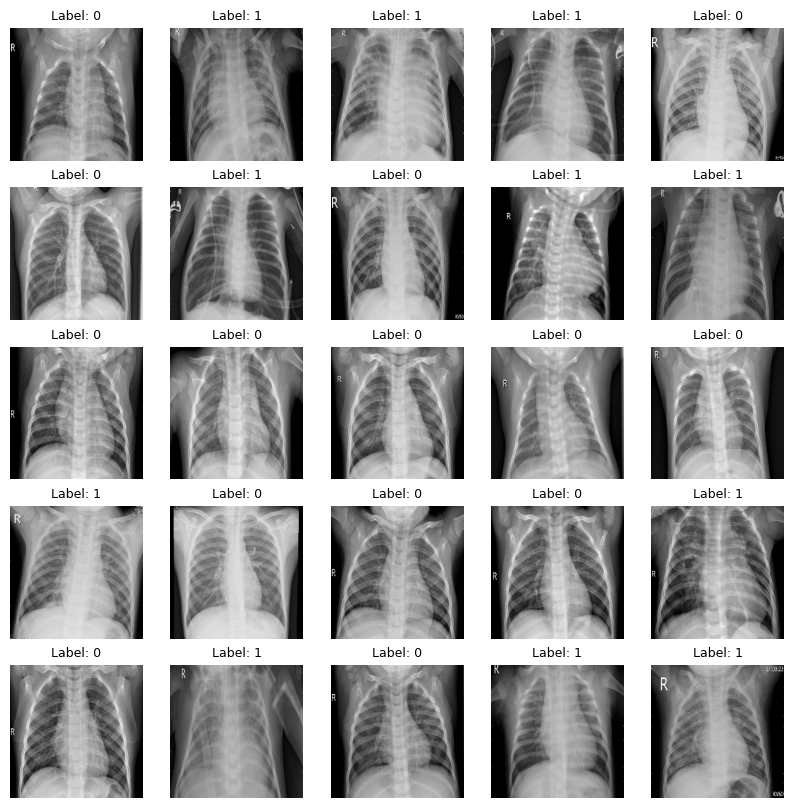

In [ ]:
printImg(X_test,y_test,False)

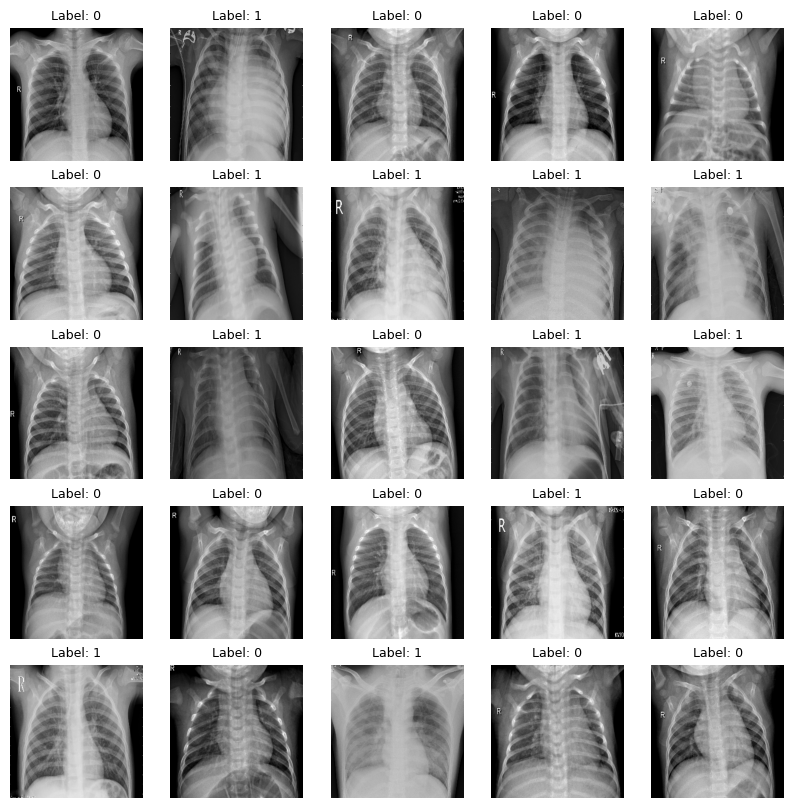

In [ ]:
printImg(X_train,y_train,False)

# Argumentos de entrada

In [ ]:
# Reseta os ids das camadas
tf.keras.backend.clear_session()

# treinamento em batch (blocos de entradas)
batch_size = 64
# numero de epocas que iremos treinar o algoritmo
epochs = 50

peso_normal = (1 / class_counts[0]) * (total_samples / 2.0)
peso_pneu = (1 / class_counts[1]) * (total_samples / 2.0)
print(f'Peso Normal: {peso_normal}')
print(f'Peso Pneumonia: {peso_pneu}')

# Dimensoes das imagem de entrada

img_rows = img_cols = X_train.shape[1]
input_shape = X_train.shape[1:]
print(f'input_shape: {input_shape}')

Peso Normal: 1.9448173005219984
Peso Pneumonia: 0.6730322580645162
input_shape: (256, 256, 1)


# CNN

In [ ]:
# Reseta os ids das camadas
tf.keras.backend.clear_session()

# Modelo base usado é o VGG16
# VGG16 (Visual Geometry Group 16) é uma arquitetura de rede neural convolucional (CNN)
# desenvolvida por pesquisadores da Universidade de Oxford
base_model=VGG16(include_top=False,weights="imagenet",input_shape=(IMG_SIZE,IMG_SIZE,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:


model = tf.keras.models.Sequential([

    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Conv2D(3, (3,3), padding="same"),
    # Conv2D resulta em um tensor de 3 camadas, pois VGG16 requer a utlizaçao de 3 camadas
    base_model,
    tf.keras.layers.Flatten(),
    BatchNormalization(),
    Dropout(0.5),
    tf.keras.layers.Dense(1028, activation='relu'),
    Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
# Utilizado para congelar as camadas do modelo para que não sejam atualizadas no treinamento
# Processo comum em transfer learning, onde usamos um modelo pré-treinado (no caso, VGG16)
# como base e apenas ajustando as camadas finais.
base_model.trainable=False

In [ ]:
# Modelo é utilizado o otimizador Adam juntamente com a função de perda "binary_crossentropy"
# utilizada para problemas de classificação binaria, baseada na entropia cruzada, que
# mede a discrepância entre as distribuições de probabilidade das classes preditas e reais.
# As metricas utlizadas foram a acuracia, o Recall e a precisão.
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', Recall(), Precision()])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 3)         │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32768)               │         131,072 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1028)                │      33,686,532 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1028)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         526,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,234,275 (187.81 MB)

 Trainable params: 34,454,051 (131.43 MB)

 Non-trainable params: 14,780,224 (56.38 MB)

In [ ]:
# Usado para monitorar e parar o treinamento caso a metrica val_loss
# nao melhorar pelo numero definido de epocas (patience). Usado para evitar
# overfitting.
earlystop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    min_delta=0,
    restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    verbose=1,
    validation_split=0.2,
    callbacks=[earlystop]
)

scores = model.evaluate(
    X_test,
    y_test,
    verbose=1
)

print(f'Test loss: {scores[0]}')
print(f'Test accuracy: {scores[1]}')

Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 166s 964ms/step - accuracy: 0.4757 - loss: 1.6516 - precision: 0.6707 - recall: 0.4391 - val_accuracy: 0.8420 - val_loss: 0.6605 - val_precision: 1.0000 - val_recall: 0.8420
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 109s 530ms/step - accuracy: 0.5546 - loss: 1.0309 - precision: 0.7142 - recall: 0.5684 - val_accuracy: 0.9464 - val_loss: 0.5718 - val_precision: 1.0000 - val_recall: 0.9464
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 68s 522ms/step - accuracy: 0.5649 - loss: 0.9245 - precision: 0.7231 - recall: 0.5767 - val_accuracy: 0.9617 - val_loss: 0.4750 - val_precision: 1.0000 - val_recall: 0.9617
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 80s 510ms/step - accuracy: 0.5955 - loss: 0.8111 - precision: 0.7257 - recall: 0.6456 - val_accuracy: 0.9282 - val_loss: 0.3884 - val_precision: 1.0000 - val_recall: 0.9282
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 84s 528ms/step - accuracy: 0.6457 - loss: 0.7271 - precision: 0.7600 - recall: 0.6952 - val_accuracy: 0.94

In [ ]:
# Faça a predição do modelo no teste
predictions = model.predict(X_test)
# Pega as labels das predições
predicted_labels = (predictions > 0.5).astype(int)
predicted_labels = predicted_labels.flatten()
# Pega as labels reais
true_labels = y_test
correct_predictions = 0
incorrect_predictions = 0
for i in range(len(predicted_labels)):
  print(f"Pred: {predicted_labels[i]},True: {true_labels[i]}")
  if(predicted_labels[i] == true_labels[i]):
    correct_predictions = correct_predictions+1
  else:
    incorrect_predictions = incorrect_predictions+ 1
total_samples = len(y_test)

# Exibindo os resultados
print(f"Número de predições totais: {total_samples}")
print(f"Número de predições corretas: {correct_predictions}")
print(f"Número de predições erradas: {incorrect_predictions}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step
Pred: 0,True: 0
Pred: 1,True: 0
Pred: 1,True: 0
Pred: 1,True: 0
Pred: 0,True: 0
Pred: 1,True: 0
Pred: 1,True: 0
Pred: 1,True: 0
Pred: 0,True: 0
Pred: 0,True: 0
Pred: 0,True: 0
Pred: 0,True: 0
Pred: 0,True: 0
Pred: 0,True: 0
Pred: 0,True: 0
Pred: 0,True: 0
Pred: 1,True: 0
Pred: 0,True: 0
Pred: 0,True: 0
Pred: 0,True: 0
Pred: 0,True: 0
Pred: 0,True: 0
Pred: 0,True: 0
Pred: 0,True: 0
Pred: 0,True: 0
Pred: 1,True: 0
Pred: 1,True: 0
Pred: 0,True: 0
Pred: 0,True: 0
Pred: 0,True: 0
Pred: 0,True: 0
Pred: 1,True: 0
Pred: 0,True: 0
Pred: 0,True: 0
Pred: 1,True: 0
Pred: 0,True: 0
Pred: 1,True: 0
Pred: 0,True: 0
Pred: 0,True: 0
Pred: 0,True: 0
Pred: 1,True: 0
Pred: 0,True: 0
Pred: 1,True: 0
Pred: 0,True: 0
Pred: 0,True: 0
Pred: 0,True: 0
Pred: 1,True: 0
Pred: 1,True: 0
Pred: 1,True: 0
Pred: 1,True: 0
Pred: 0,True: 0
Pred: 1,True: 0
Pred: 0,True: 0
Pred: 1,True: 0
Pred: 1,True: 0
Pred: 1,True: 0
Pred: 0,True: 0
Pred: 0,True: 0
Pred: 1,True: 0
Pred: 1,True: 0

In [ ]:
# Calculando o número de predições corretas
correct_predictions2 = np.sum(predicted_labels == true_labels)

# Calculando o número de predições erradas
incorrect_predictions2 = np.sum(predicted_labels != true_labels)

# Exibindo os resultados
print(f"Número de predições corretas: {correct_predictions2}")
print(f"Número de predições erradas: {incorrect_predictions2}")

Número de predições corretas: 526
Número de predições erradas: 98


In [ ]:
loss = scores[0]
accuracy = scores[1]
recall = scores[2]
precision = scores[3]

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test recall: {recall}")
print(f"Test precision: {precision}")

Test Loss: 1.103435754776001
Test Accuracy: 0.8429487347602844
Test recall: 0.9948717951774597
Test precision: 0.8016529083251953


Quantidade de Previsões erradas: 98
Indices Selecionados: [100 196  48  89 176 186 143   5 193 216 179  77 198 102 155 515 138  89
   6 102   7 515 515  91 184]


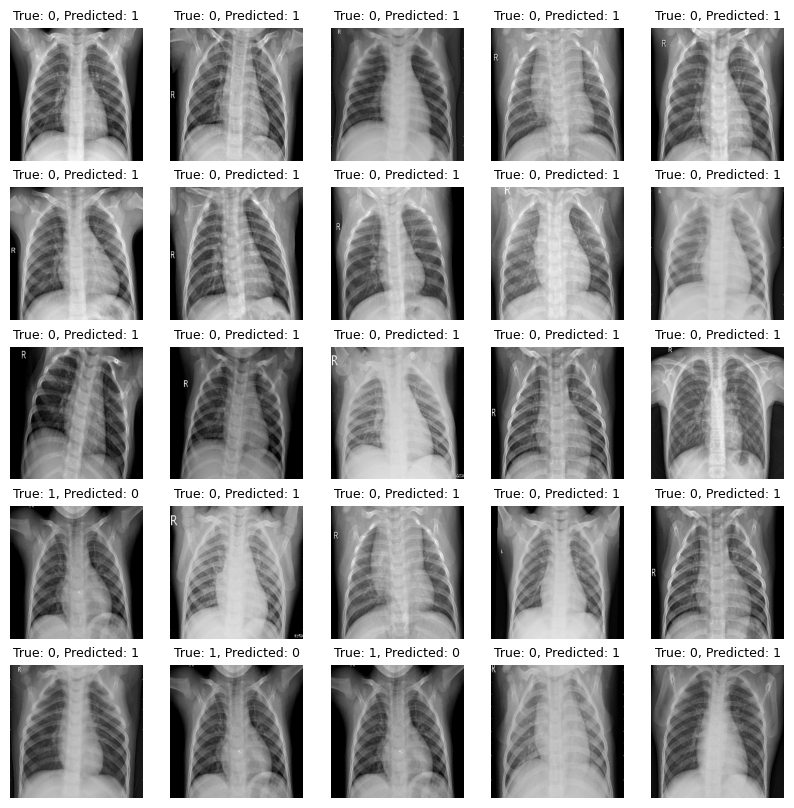

In [ ]:
# Print das imagens, WrongPred = True para as predições erradas
PrintImgWrong(X_test,predicted_labels,true_labels,WrongPred = True)

Quantidade de Previsões corretas: 526
Indices Selecionados: [314 389 422 277 224  95 571 339 514 106 601 489 385 441 404  96 361 146
  14 251 546  28 476  63 603]


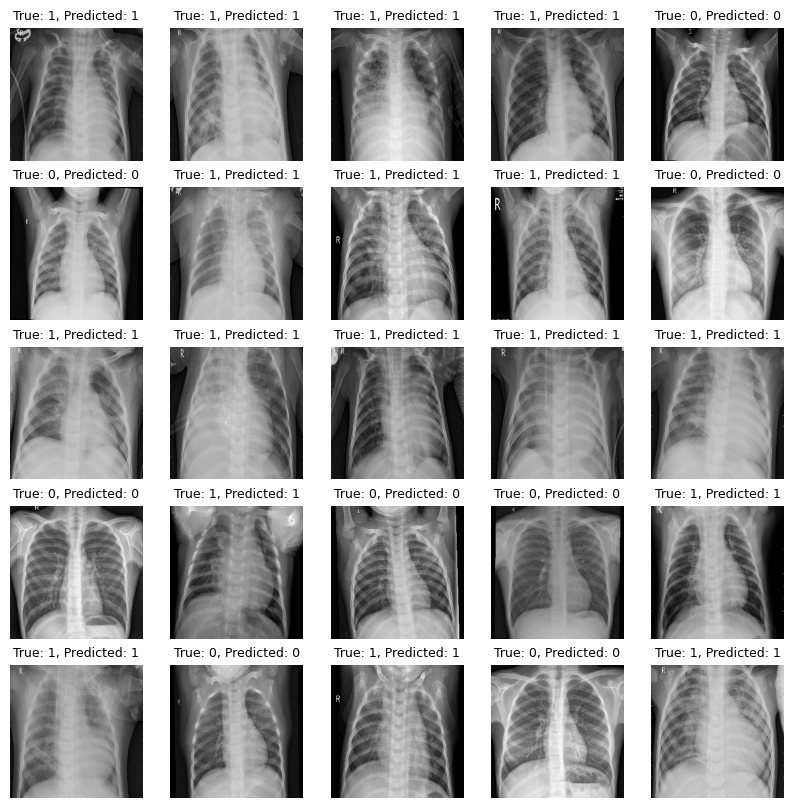

In [ ]:
# Print das imagens, WrongPred = False para as predições corretas
PrintImgWrong(X_test,predicted_labels,true_labels,WrongPred = False)

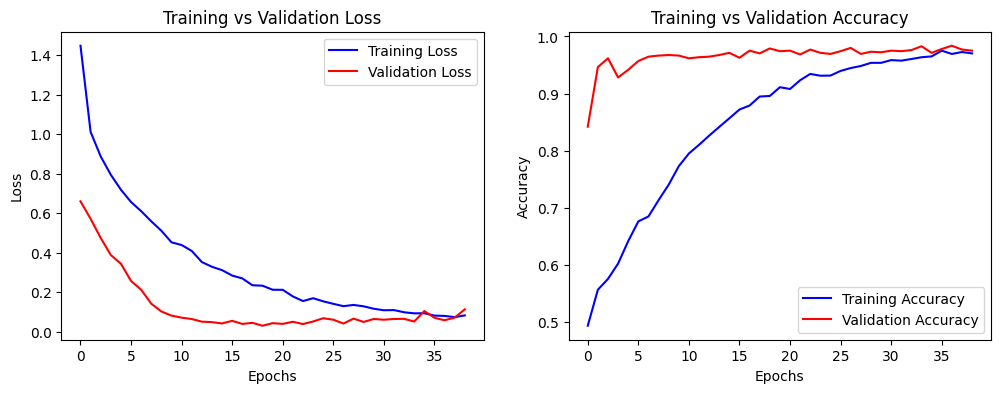

In [ ]:
history_dict = history.history

# Plotando Training Loss e Validation Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss', color='blue')
plt.plot(history_dict['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plotando Training Accuracy e Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.show()

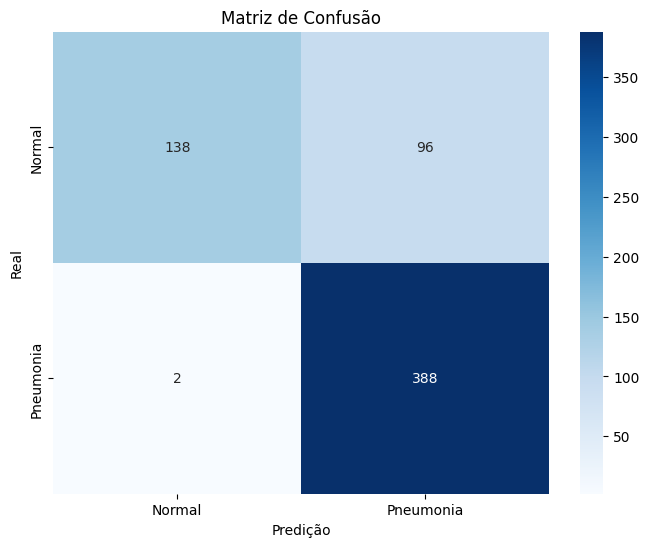

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Gerar a matriz de confusão
y_true = true_labels# Substitua pelo vetor de rótulos reais
y_pred = predicted_labels# Substitua pelo vetor de previsões feitas pelo modelo

cm = confusion_matrix(y_true, y_pred)

# Plotando a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()